In [1]:
import os
import torch
from layers import SpatialTransformer
import numpy as np
import nibabel as nib

from skimage.transform import resize
from scipy.ndimage.interpolation import affine_transform

from helpers import normalizeImage, random_transform, compute_negative_jacobian
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [14]:
folder = "/mnt/blackhole-data2/RadOnc_Brain"
write_dir = '/home/myi16/jsr_Y/test_val'

CT_min = -100.0
CT_max = 100.0
CBCT_min = -100.0
CBCT_max = 100.0
T1_min = -100.0 ##?
T1_max = 2300.0 ## ?
config = dict()

config['image_size'] = [128, 160, 128]
config['num_samples'] = 10
config['augment_translation'] = 5
config['augment_rotation'] = 5
config['augment_n_points'] = [1, 5]  # number of points in deformation simulation
config['augment_decay_power_range'] =  [10*5e-3, 10*3e-2] # [1e-2,1e-1] [3e-2,5e-2] [5e-2,9e-2] [9e-3,3e-2] [6e-3,9e-3] # decay power range in deformation simulation
config['augment_deformation_range'] = [1.5, 4]  # deformation magnitude range in deformation simulation

In [5]:
indices = np.arange(46,50)
n_moving = []
n_fixed = []
n_cbct = []
n_mask_ventricle = []
n_mask_brain = []
for i in indices:
    n_fixed.append(nib.load(os.path.join(folder,f"NormalAnatomy",f"atlas_brain_{i:02}_CT-crop-resampled.nii")).get_fdata())
    n_cbct.append(nib.load(os.path.join(folder,f"NormalAnatomy",f"atlas_brain_{i:02}_CBCT_OArm-crop-resampled.nii")).get_fdata())
    n_moving.append(nib.load(os.path.join(folder, f"NormalAnatomy", f"atlas_brain_{i:02}_T1-crop-resampled.nii")).get_fdata())
    n_mask_ventricle.append(np.squeeze(nib.load(os.path.join(folder, f"MALPEM-MR-Brain-Segmentations",
                                                             f"atlas_brain_{i:02}_T1-crop-resampled_MALPEM.nii.gz")).get_fdata()))
    n_mask_brain.append(nib.load(os.path.join(folder, f"NormalAnatomy_Mask", f"atlas_brain_{i:02}_brain_mask.nii.gz")).get_fdata())

In [8]:
from layers import VecInt
from scipy.ndimage import distance_transform_edt as bwdist

class SourceWarpPoint:
    def __init__(self, point, decay_power=1, deformation_magnitude=6):

        # Default values
        self.decay_power = decay_power
        self.deformation_magnitude = deformation_magnitude
        self.point = point

    def print(self):
        print('point: ', self.point, ' decay power: ', self.decay_power,
              ' deformation magnitude: ', self.deformation_magnitude)


class SourceGen:
    """
    Randomly generate source points with:
    n_points: number of source points to drive deformation
    random decay power: min and max value
    deformation magnitude: min and max value
    Source points are randomly located with a given mask (e.g ventricle)
    """
    def __init__(self, n_points, image_shape, decay_power_range=[0.5, 2], deformation_magnitude_range=[1, 5]):
        self.image_shape = image_shape
        self.decay_power_range = decay_power_range
        self.deformation_magnitude_range = deformation_magnitude_range
        self.n_points = n_points

    def run(self, ventricle_mask=None):
        points = []
        sources = []

        if ventricle_mask is None:
            x, y, z = np.meshgrid(np.linspace(0, self.image_shape[0]-1, self.image_shape[0]),
                                  np.linspace(0, self.image_shape[1]-1, self.image_shape[1]),
                                  np.linspace(0, self.image_shape[2]-1, self.image_shape[2]))
        else:
            islice = np.argmax(np.sum(ventricle_mask > 0, axis=(0, 1)))  # find the slice with the largest masked volume
            mask_center = np.zeros(ventricle_mask.shape)
            mask_center[:, :, islice-5:islice+4] = ventricle_mask[:, :, islice - 5:islice + 4]  # only place sources around ±5 slices from islice
            x, y, z = np.where(mask_center > 0)

        index = np.random.randint(len(x), size=self.n_points)
        for i in range(self.n_points):
            points.append([x[index[i]], y[index[i]], z[index[i]]])
            alpha = np.random.uniform(low=self.deformation_magnitude_range[0], high=self.deformation_magnitude_range[1])
            beta_exp = np.random.uniform(low=np.log(self.decay_power_range[0]),
                                         high=np.log(np.minimum(self.decay_power_range[1], np.log2(alpha/(alpha-1)))))
            beta = np.exp(beta_exp)

            sources.append(SourceWarpPoint(point=points[i], decay_power=beta,
                                           deformation_magnitude=alpha*np.random.choice([-1, 1])))
        return sources


class Simulator:
    """
    Simulate a random deformation field based on source model D=a/r^b from multiple source points.

    Returns
    -------
    D : the overall deformation field

    """

    def __init__(self, image_size=[192, 240, 192], int_steps=10,unit = False):

        self._image_size = image_size
        # self.transformer = SpatialTransformer(image_size, mode=interp_method)
        self.vectint = VecInt(image_size, int_steps)  # square and scaling layer for exponentiation
        self.unit = unit

    def simulate(self, sources, brain_mask=None, thresh=30):
        """
        sources: sources to drive deformation, generated from SourceGen
        brain_mask: optional mask of the brain region, deformation outside is set to 0
        thresh: a threshold of the distance to the brain boundary (value above thresh is not affected)
        """
        [X, Y, Z] = np.mgrid[0:self._image_size[0], 0:self._image_size[1], 0:self._image_size[2]]
        D = np.zeros((3, self._image_size[0], self._image_size[1], self._image_size[2]))
        
        for source in sources:
            decay_power = source.decay_power
            deformation_mag = source.deformation_magnitude
        
            if self.unit:
                R2 = np.square((X-source.point[0])*1.5/0.7) + np.square((Y-source.point[1])*1.5/0.7) + np.square((Z-source.point[2])*1.5)
            else:
                R2 = np.square((X-source.point[0])) + np.square((Y-source.point[1])) + np.square((Z-source.point[2]))
            F = deformation_mag/(np.power(R2, decay_power/2)+1e-6) # deformation magnitude (+retraction,-dilation)
            F[source.point[0], source.point[1], source.point[2]] = deformation_mag

            # DX = (X-source.point[0])/(np.sqrt(R2)+1e-5)*F*(0.7/1.5)**(1-decay_power)
            # DY = (Y-source.point[1])/(np.sqrt(R2)+1e-5)*F*(0.7/1.5)**(1-decay_power)
            # DZ = (Z-source.point[2])/(np.sqrt(R2)+1e-5)*F*(1/1.5)**(1-decay_power)
            
            # DX = (X-source.point[0])/(np.sqrt(R2)+1e-5)*F*(0.7/1.5)
            # DY = (Y-source.point[1])/(np.sqrt(R2)+1e-5)*F*(0.7/1.5)
            # DZ = (Z-source.point[2])/(np.sqrt(R2)+1e-5)*F*(1/1.5)

            DX = (X-source.point[0])/(np.sqrt(R2)+1e-5)*F
            DY = (Y-source.point[1])/(np.sqrt(R2)+1e-5)*F
            DZ = (Z-source.point[2])/(np.sqrt(R2)+1e-5)*F
            
            # DX[source.point[0],:,:] = deformation_mag
            # DY[:,source.point[1],:] = deformation_mag
            # DZ[:,:,source.point[2]] = deformation_mag
            

            D = D + np.stack((DX, DY, DZ), axis=0)
            

        if brain_mask is not None:  # set deformation outside the brain to 0 with smooth transitions
            brain_dist = bwdist(brain_mask) / 30
            brain_dist[brain_dist > 1] = 1
            D = np.multiply(D, np.repeat(brain_dist[np.newaxis, :, :], 3, axis=0))

        D = self.vectint(torch.from_numpy(D).unsqueeze(0).float())
        
        return D
    



In [19]:

# simulator = Simulator(image_size=config['image_size'])
original_shape = config['image_size']
transformer_linear = SpatialTransformer(original_shape, mode='bilinear')
transformer_nearest = SpatialTransformer(original_shape, mode='nearest')

In [20]:
from tqdm import tqdm
for i in tqdm(range(config['num_samples'])):
    index = np.random.randint(len(n_moving))
    #index = np.mod(i,5)
    #index = 0
    ct = resize(n_fixed[index],config['image_size'], order=3)
    mr = resize(n_moving[index],config['image_size'], order=3)
    cbct = resize(n_cbct[index],config['image_size'], order=3)

    mask_ventricle = resize(n_mask_ventricle[index],config['image_size'], order=0, anti_aliasing=False).astype(np.int8)
    mask_brain = resize(n_mask_brain[index],config['image_size'], order=0, anti_aliasing=False).astype(np.int8)

    # Apply rigid transformation
    T = random_transform(list(np.shape(mr)), config['augment_translation'], config['augment_rotation'])
    ct = affine_transform(ct, T, mode='nearest')
    mr = affine_transform(mr, T, mode='nearest')
    cbct = affine_transform(cbct, T, mode='nearest')
    mask_ventricle = affine_transform(mask_ventricle, T, mode='nearest', order=0)
    mask_brain = affine_transform(mask_brain, T, mode='nearest', order=0)

    # Simulate deformations
    n_points = np.random.randint(config['augment_n_points'][0], config['augment_n_points'][1])
    source_gen= SourceGen(n_points, original_shape, decay_power_range=config['augment_decay_power_range'], deformation_magnitude_range=config['augment_deformation_range'])
    sources = source_gen.run(ventricle_mask=(mask_ventricle == 23) + (mask_ventricle == 24))
    sim = Simulator(original_shape)
    flow = sim.simulate(sources, mask_brain)
    flow[0,0,:,:,:] *= config['image_size'][0]/n_moving[index].shape[0]
    flow[0,1,:,:,:] *= config['image_size'][1]/n_moving[index].shape[1]
    flow[0,2,:,:,:] *= config['image_size'][2]/n_moving[index].shape[2]

    ct = torch.from_numpy(ct).unsqueeze(0).unsqueeze(0).float()
    ct_deform = transformer_linear(ct, flow)
    mr = torch.from_numpy(mr).unsqueeze(0).unsqueeze(0).float()
    mr_deform = transformer_linear(mr, flow)
    cbct = torch.from_numpy(cbct).unsqueeze(0).unsqueeze(0).float()
    cbct_deform = transformer_linear(cbct, flow)
    mask = torch.from_numpy(mask_ventricle).unsqueeze(0).unsqueeze(0).float()
    mask_deform = transformer_nearest(mask, flow)

    mr = normalizeImage(mr, T1_max, T1_min)
    mr_deform = normalizeImage(mr_deform, T1_max, T1_min)
    ct = normalizeImage(ct, CT_max, CT_min)
    ct_deform = normalizeImage(ct_deform, CT_max, CT_min)
    cbct = normalizeImage(cbct, CBCT_max, CBCT_min)
    cbct_deform = normalizeImage(cbct_deform, CBCT_max, CBCT_min)
    
    # data = {'ct_fixed':ct.squeeze(0).squeeze(0).numpy(), 'mr_moving':mr_deform, 'ct_moving':ct_deform.squeeze(0).squeeze(0).numpy(),
    #          'moving_truth':mr.squeeze(0).squeeze(0).numpy(), 'seg_fixed':mask, 'seg_moving':mask_deform,
    #          'affine':T, 'flow':flow.squeeze().numpy(), #'sources':sources,
    #          'cbct_fixed':cbct, 'cbct_warp':cbct_deform.squeeze(0).squeeze(0).numpy(), 'index':index}
    # torch.save(data,os.path.join(write_dir, f"{i:03}.pt"))
    np.savez(os.path.join(write_dir, f"{i:03}.npz"),
             fixed_img=ct.squeeze(0).squeeze(0), moving_img=mr_deform.squeeze(0).squeeze(0), fixed_warp=ct_deform.squeeze(0).squeeze(0),
             moving_truth=mr.squeeze(0).squeeze(0), ventricle_fixed=mask.squeeze(0).squeeze(0), ventricle_moving=mask_deform.squeeze(0).squeeze(0),
             affine=T, flow=flow.squeeze().numpy(), sources=sources,
             cbct=cbct.squeeze(0).squeeze(0), cbct_warp=cbct_deform.squeeze(0).squeeze(0), index=index)

 


100%|██████████| 400/400 [1:40:05<00:00, 15.01s/it]


In [22]:
for source in sources:
    print((source.point[0]))

55
74


In [15]:
for keys in data.keys():
    print(keys)
    print(data[keys].shape)
    print(type(data[keys]))

ct_fixed
(128, 160, 128)
<class 'numpy.ndarray'>
mr_moving
torch.Size([1, 1, 128, 160, 128])
<class 'torch.Tensor'>
ct_moving
(128, 160, 128)
<class 'numpy.ndarray'>
moving_truth
(128, 160, 128)
<class 'numpy.ndarray'>
seg_fixed
torch.Size([1, 1, 128, 160, 128])
<class 'torch.Tensor'>
seg_moving
torch.Size([1, 1, 128, 160, 128])
<class 'torch.Tensor'>
affine
(4, 4)
<class 'numpy.ndarray'>
flow
(3, 128, 160, 128)
<class 'numpy.ndarray'>
sources


AttributeError: 'list' object has no attribute 'shape'

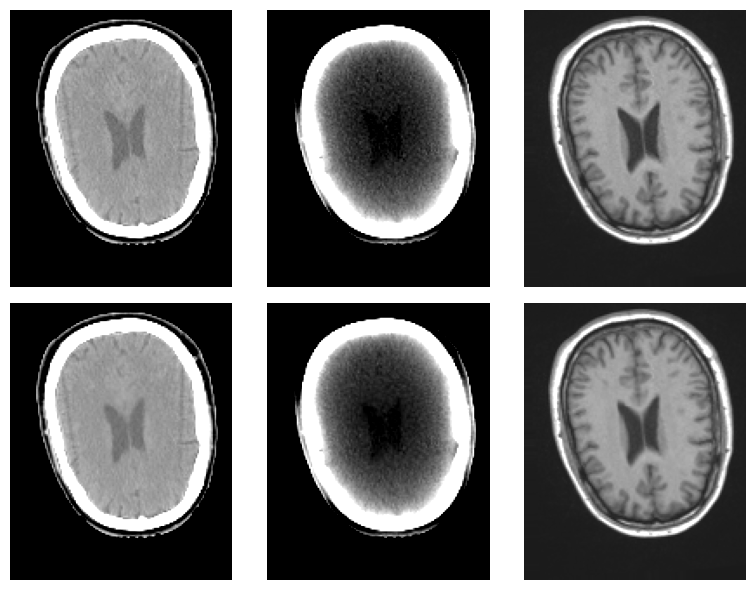

In [13]:
islice = 70
fig, ax = plt.subplots(2,3,figsize=(8,6))
np.vectorize(lambda ax: ax.axis('off'))(ax)
ax[0, 0].imshow(ct[0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[1, 0].imshow(ct_deform[0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[0, 1].imshow(cbct[0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[1, 1].imshow(cbct_deform[0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[0, 2].imshow(mr[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[1, 2].imshow(mr_deform[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
plt.tight_layout()
plt.show()

In [25]:
from tqdm import tqdm
for i in tqdm(range(400)):
    data_dict = torch.load(os.path.join(write_dir, f"{i:03}.pt"))
    
    fixed_img = data_dict['ct_fixed']
    moving_img = data_dict['mr_moving']
    fixed_warp = data_dict['ct_moving']
    moving_truth = data_dict['moving_truth']
    ventricle_fixed = data_dict['seg_fixed']
    ventricle_moving = data_dict['seg_moving']
    affine = data_dict['affine']
    flow = data_dict['flow']
    cbct = data_dict['cbct_fixed']
    cbct_warp = data_dict['cbct_warp']

    output_dict = {}
    output_dict['fixed_img'] = fixed_img[0,0,:,:,:]
    output_dict['moving_img'] = moving_img.squeeze(0).squeeze(0).numpy()
    output_dict['fixed_warp'] = fixed_warp[0,0,:,:,:]
    output_dict['moving_truth'] = moving_truth.squeeze(0).squeeze(0).numpy()
    output_dict['ventricle_fixed'] = ventricle_fixed.squeeze(0).squeeze(0).numpy()
    output_dict['ventricle_moving'] = ventricle_moving.squeeze(0).squeeze(0).numpy()
    output_dict['affine'] = affine 
    output_dict['flow'] = flow.squeeze(0).numpy()
    output_dict['cbct'] = cbct.squeeze(0).squeeze(0).numpy()
    output_dict['cbct_warp'] = cbct_warp.squeeze(0).squeeze(0).numpy()

    np.savez(os.path.join(write_dir, f"{i:03}.npz"),
             fixed_img=fixed_img[0,0,:,:,:], moving_img=moving_img.squeeze(0).squeeze(0).numpy(), fixed_warp= fixed_warp[0,0,:,:,:],
             moving_truth=moving_truth.squeeze(0).squeeze(0).numpy(), ventricle_fixed=ventricle_fixed.squeeze(0).squeeze(0).numpy(), ventricle_moving=ventricle_moving.squeeze(0).squeeze(0).numpy(),
             affine=affine, flow=flow.squeeze(0).numpy(), sources=None,
             cbct=cbct.squeeze(0).squeeze(0).numpy(), cbct_warp=cbct_warp.squeeze(0).squeeze(0).numpy(), index=i)

    

100%|██████████| 400/400 [01:25<00:00,  4.65it/s]


In [1]:
import os

# 指定要删除文件的目录路径
directory = "/home/myi16/jsr_Y/md4_val"
# 获取目录中的所有文件名
file_list = os.listdir(directory)

# 遍历文件列表并删除每个文件
for filename in file_list:
    if filename.endswith('.pt'):
        file_path = os.path.join(directory, filename)
        try:
            # 删除文件
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

Deleted: /home/myi16/jsr_Y/new_data/081.pt
Deleted: /home/myi16/jsr_Y/new_data/399.pt
Deleted: /home/myi16/jsr_Y/new_data/339.pt
Deleted: /home/myi16/jsr_Y/new_data/204.pt
Deleted: /home/myi16/jsr_Y/new_data/099.pt
Deleted: /home/myi16/jsr_Y/new_data/247.pt
Deleted: /home/myi16/jsr_Y/new_data/210.pt
Deleted: /home/myi16/jsr_Y/new_data/274.pt
Deleted: /home/myi16/jsr_Y/new_data/200.pt
Deleted: /home/myi16/jsr_Y/new_data/055.pt
Deleted: /home/myi16/jsr_Y/new_data/125.pt
Deleted: /home/myi16/jsr_Y/new_data/082.pt
Deleted: /home/myi16/jsr_Y/new_data/315.pt
Deleted: /home/myi16/jsr_Y/new_data/091.pt
Deleted: /home/myi16/jsr_Y/new_data/020.pt
Deleted: /home/myi16/jsr_Y/new_data/296.pt
Deleted: /home/myi16/jsr_Y/new_data/006.pt
Deleted: /home/myi16/jsr_Y/new_data/114.pt
Deleted: /home/myi16/jsr_Y/new_data/076.pt
Deleted: /home/myi16/jsr_Y/new_data/205.pt
Deleted: /home/myi16/jsr_Y/new_data/005.pt
Deleted: /home/myi16/jsr_Y/new_data/165.pt
Deleted: /home/myi16/jsr_Y/new_data/187.pt
Deleted: /h